In [97]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
from numpy import diff
from tqdm import tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from pycbc.types import TimeSeries, FrequencySeries
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI
import scipy.optimize
import lal
from pycbc import waveform, types
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries, FrequencySeries
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI
import scipy.optimize
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match

In [98]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import matplotlib as mpl

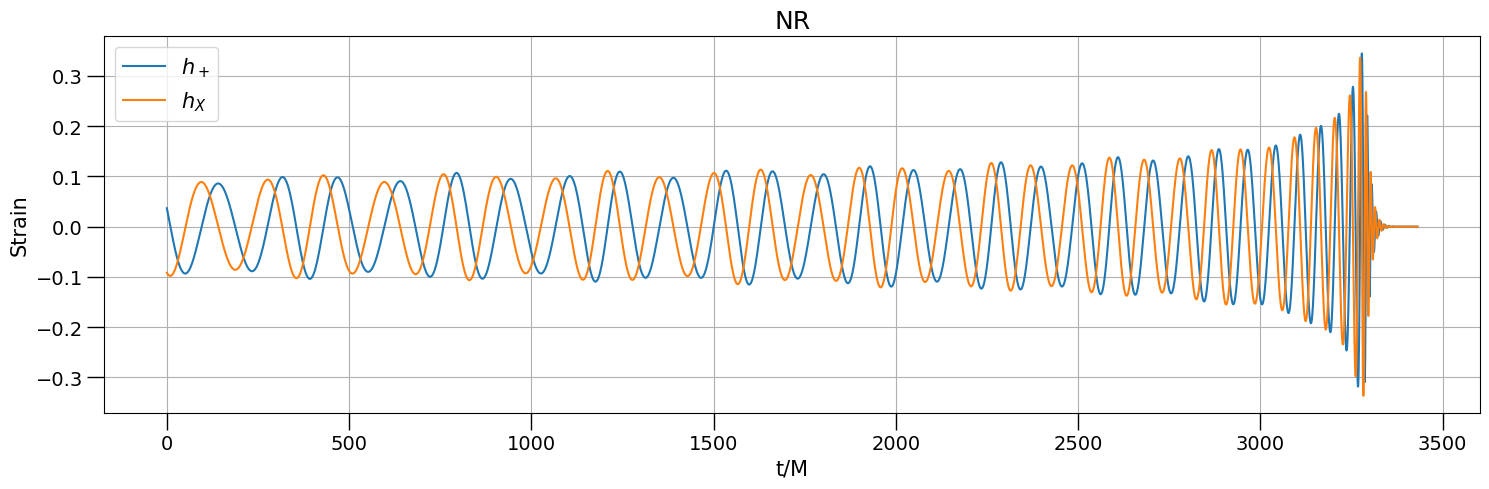

In [99]:
#NR
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 2 #modes
mp = 2
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

plt.figure(figsize=(15,5))
plt.plot(x1,y1,label='$h_+$')
plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
plt.title("NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

In [100]:
#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.125310221261021 #0.0962654051494743  
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.045 
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec 
hcVec= hl2m2cVec 
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

In [101]:
print(len(tVec_SI),len(hpVec_SI),len(hcVec_SI))

13578 13578 13578


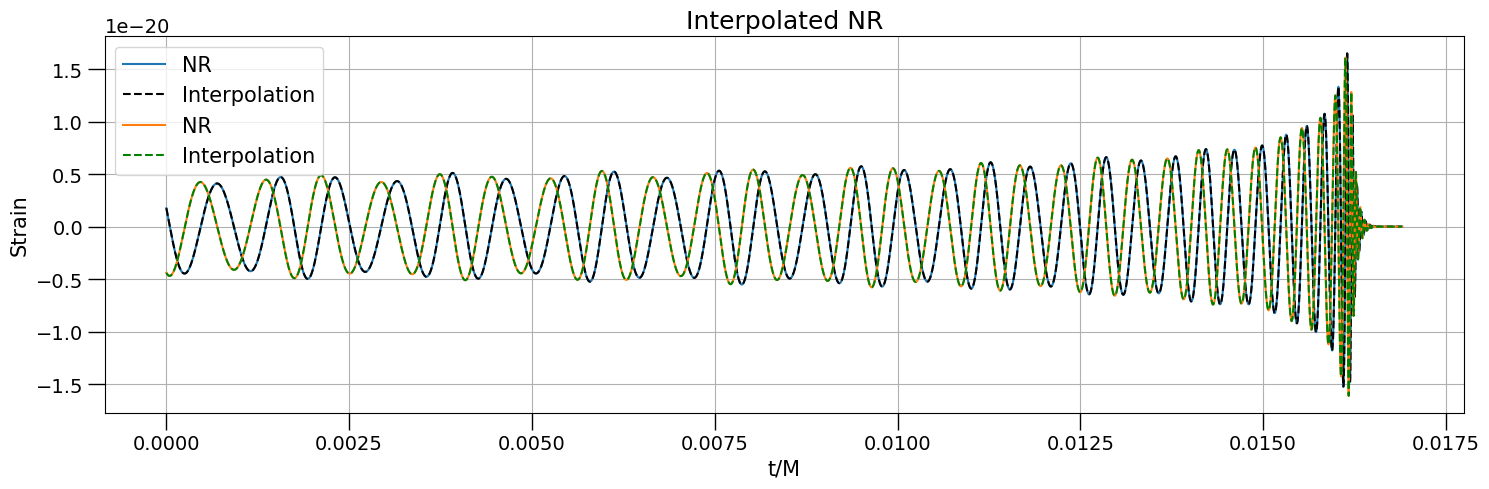

In [102]:


delta_t_NR = 1/2**20

delta_t_common=delta_t_NR
t=tVec_SI

#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR + 1j*hcVec_NR)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


plt.figure(figsize=(15,5))
plt.plot(tVec_SI,hpVec_SI,label='NR') 
plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

plt.plot(tVec_SI,hcVec_SI,label='NR') 
plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

plt.title("Interpolated NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})

In [103]:
#PN

phiC=phase_NR[mergIdx_NR]                 
tC_NR=max(hpVec_NR.sample_times)
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma= 0.577215664901

%run GW_functions.ipynb
mt=M                        #Total mass of eccentricTD wf 
m_sun=MSUN_SI                #Mass of sun in seconds
conv=mt*MTSUN_SI              #total mass (needed to convert PN time t to t/M)

#Formula to compute f from a given x
def freq(u,mass):
    return math.pow(u,3.0/2.0)/(2 * MTSUN_SI * mass * lal.PI / 2)   # f = x^(3/2) * c^3 / (G * M * 2pi/mp), mp = 2 for 22 mode
                                                                    # for 22 mode of EccTD, mp=2
f_low=freq(xlow,mt)            #Lower frequency of EccTD wf which is in our hands
f_ref=freq(xref,mt)            #Ref frequency of EccTD wf

####################################################

#Calculating ecc at xlow for generating EccTD wf-->eccentricity evolution Eq. (4.17a,b) Moore et. al.(2016)

%run GW_functions.ipynb         #Notebook with all PN evolution equations
x=xlow                         #x=point where eccentricity is required
v=math.sqrt(x)
vref=math.sqrt(xref)
xie=v**3
xiref=vref**3

#Gives e at xie with b.c.--> e=eref when xie=xiref

e=eref*(xiref/xie)**(19/18)*epsilon(xie, eta)/epsilon(xiref, eta)


In [104]:
print(e,e0)
print(f_low)  ## 22 mode frequency
print(f_ref)  ## 22 mode frequency
## PyCBC generates 22 mode only, so frequency for 22 mode required

0.12491576739528563 0.125310221261021
616.9065279526923
1327.3715049596763


In [105]:
hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                         delta_t=delta_t_common, 
                         f_lower=f_low, 
                         eccentricity=e0,
                         distance=1)

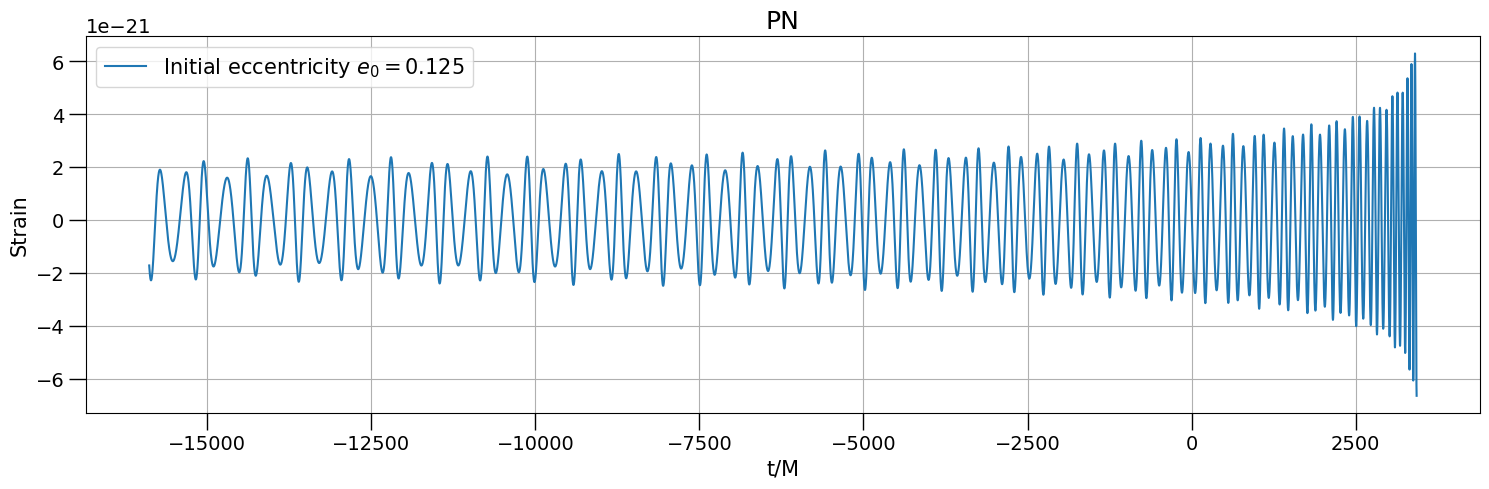

In [106]:
plt.figure(figsize=(15,5))
tVec_PN_shifted=tC_NR+hpVec_PN.sample_times
plt.plot(tVec_PN_shifted/conv,hpVec_PN,label='Initial eccentricity $e_0=%1.3f$' %e)
plt.title("PN",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})

In [107]:
## eccentricTD from PyCBC is 22 mode, hence the modetopolfac value is for 22 mode
phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)))

In [108]:
## PyCBC generates only the 2,2 mode. So modetopolfac for 22 mode works for the PyCBC strain
tVec_PN_GM=tVec_PN_shifted/conv
tVec_NR_GM=tVec_NR/conv
hpVec_PN_GM=hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))
hcVec_PN_GM=hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))

In [109]:
tC_NR=tC_NR/conv
tC_NR

3430.9490767681923

In [110]:
#%run GW_functions.ipynb 

tVec_PN=tVec_PN_GM
tC_NR=tC_NR


xi_ref=xref**(3/2)
v_ref=xi_ref**(1/3)
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
l0=mean_anomaly(xi_ref, xi0, lref, eta,e0)
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)

In [111]:
####xiVec=(2*np.pi*M*fVec/mp)  ### probable relation for higher modes

xiVec=(np.pi*M*fVec)   ### might be for 22 mode only
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)

In [112]:
for i in range(0,len(xVec)):
    if xVec[i]>=0.1025:
        print(i)
        break
lst = 100105


98392


In [113]:
#selct +ve frequencies
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=xiVec[plotIdx2]
xVec=xVec[plotIdx2]
vVec=vVec[plotIdx2]
maxPNidx=len(xVec)

In [114]:
len(xVec), len(phase_EccTD)

(99529, 99773)

In [115]:


j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs22=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs22.append(abs(hlm))

100%|███████████████████████████████████| 99529/99529 [01:29<00:00, 1114.37it/s]


In [116]:
mp, j
NRamp = abs(hpVec_NR/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp22= NRamp
NRomega22= omega_NR
tNR22= tVec_NR_GM

PNamp22= hlm_abs22[:maxPNidx]
PNomega22= omega_PN[:maxPNidx]
tPN22= tVec_PN_GM[:maxPNidx]

# $(l,m)=(2,1)$

In [117]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 2 #modes
mp = 1
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.125310221261021 #0.0962654051494743 
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20


delta_t_common=delta_t_NR
t=tVec_SI

#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_21 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_21 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_21 + 1j*hcVec_NR_21)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


In [118]:

j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs21=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_21(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs21.append(abs(hlm))

100%|███████████████████████████████████| 99529/99529 [00:37<00:00, 2626.56it/s]


In [119]:
mp, j
NRamp = abs(hpVec_NR_21/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_21/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))

NRamp21= NRamp
NRomega21= omega_NR
tNR21= tVec_NR_GM

PNamp21= hlm_abs21[:maxPNidx]
PNomega21= omega_PN[:maxPNidx]
tPN21= tVec_PN_GM[:maxPNidx]


# $(l,m)=(3,3)$

In [120]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 3 #modes
mp = 3
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)



x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]


tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.125310221261021 #0.0962654051494743 
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec 
hcVec= hl2m2cVec 
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI


delta_t_NR = 1/2**20



delta_t_common=delta_t_NR
t=tVec_SI

#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_33 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_33 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_33 + 1j*hcVec_NR_33)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))




In [121]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs33=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_33(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs33.append(abs(hlm))

100%|███████████████████████████████████| 99529/99529 [00:47<00:00, 2116.09it/s]


In [122]:
mp, j
NRamp = abs(hpVec_NR_33/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_33/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)

phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))

NRamp33= NRamp
NRomega33= omega_NR
tNR33= tVec_NR_GM

PNamp33= hlm_abs33[:maxPNidx]
PNomega33= omega_PN[:maxPNidx]
tPN33= tVec_PN_GM[:maxPNidx]


# $(l,m)=(3,2)$

In [123]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 3 #modes
mp = 2
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)



x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]


tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]



#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.125310221261021 #0.0962654051494743 
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q


hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec 
hcVec= hl2m2cVec 
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI



delta_t_NR = 1/2**20



delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_32 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_32 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_32 + 1j*hcVec_NR_32)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))




In [124]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs32=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_32(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs32.append(abs(hlm))

100%|███████████████████████████████████| 99529/99529 [00:26<00:00, 3694.23it/s]


In [125]:
mp, j
NRamp = abs(hpVec_NR_32/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_32/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)

phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))

NRamp32= NRamp
NRomega32= omega_NR
tNR32= tVec_NR_GM

PNamp32= hlm_abs32[:maxPNidx]
PNomega32= omega_PN[:maxPNidx]
tPN32= tVec_PN_GM[:maxPNidx]


# $(l,m)=(4,4)$

In [126]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 4 #modes
mp = 4
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)



        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]


tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]


#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.125310221261021 #0.0962654051494743  
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q


hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI



delta_t_NR = 1/2**20



delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_44 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_44 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_44 + 1j*hcVec_NR_44)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))




In [127]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs44=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_44(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs44.append(abs(hlm))

100%|███████████████████████████████████| 99529/99529 [00:33<00:00, 2938.84it/s]


In [128]:
mp, j
NRamp = abs(hpVec_NR_44/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_44/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)

phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))

NRamp44= NRamp
NRomega44= omega_NR
tNR44= tVec_NR_GM

PNamp44= hlm_abs44[:maxPNidx]
PNomega44= omega_PN[:maxPNidx]
tPN44= tVec_PN_GM[:maxPNidx]

# $(l,m)=(4,3)$

In [129]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 4 #modes
mp = 3
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)



        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]


#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.125310221261021 #0.0962654051494743 
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q


hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI



delta_t_NR = 1/2**20

#print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_43 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_43 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_43 + 1j*hcVec_NR_43)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))



In [130]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs43=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_43(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs43.append(abs(hlm))

100%|███████████████████████████████████| 99529/99529 [00:30<00:00, 3242.68it/s]


In [131]:
mp, j
NRamp = abs(hpVec_NR_43/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_43/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)

phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))

NRamp43= NRamp
NRomega43= omega_NR
tNR43= tVec_NR_GM

PNamp43= hlm_abs43[:maxPNidx]
PNomega43= omega_PN[:maxPNidx]
tPN43= tVec_PN_GM[:maxPNidx]


# $(l,m)=(5,5)$

In [132]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 5 #modes
mp = 5
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)



        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)


x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]


tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]


#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.125310221261021 #0.0962654051494743 
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q


hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI


delta_t_NR = 1/2**20


delta_t_common=delta_t_NR
t=tVec_SI

#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_55 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_55 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_55 + 1j*hcVec_NR_55)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))




In [133]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs55=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_55(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs55.append(abs(hlm))

100%|███████████████████████████████████| 99529/99529 [00:37<00:00, 2624.03it/s]


In [134]:
mp, j
NRamp = abs(hpVec_NR_55/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_55/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp55= NRamp
NRomega55= omega_NR
tNR55= tVec_NR_GM

PNamp55= hlm_abs55[:maxPNidx]
PNomega55= omega_PN[:maxPNidx]
tPN55= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])

In [135]:
lst = 311900 #100050

In [136]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
mpl.rcParams['xtick.major.size'] = 12
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 12
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 8
mpl.rcParams['ytick.minor.width'] = 1

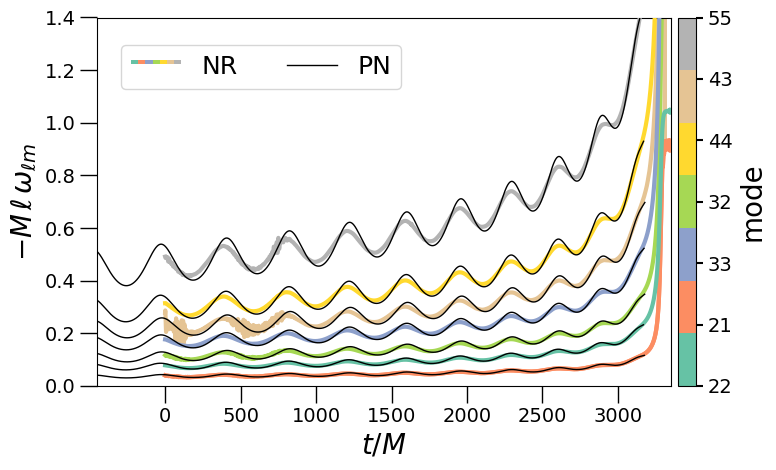

In [138]:
#plt.figure(figsize=(12,7))
plt.figure(figsize=(8,4.8))

N = 7
cmap = plt.get_cmap('Set2', N)
#colors = pl.cm.jet(np.linspace(0,1,N))
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
cbar.set_label(label='mode',size=20)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)


plt.plot(tNR22 - tNR22[0], NRomega22*2,linewidth = 3.0,c=cmap(0),zorder=4)
plt.plot(tNR21 - tNR21[0], NRomega21*2,linewidth = 3.0,c=cmap(1),zorder=3)
plt.plot(tNR21 - tNR21[0], NRomega21*2,linewidth = 3.0,c=cmap(1),zorder=3)
plt.plot(tNR33 - tNR33[0], NRomega33*3,linewidth = 3.0,c=cmap(2),zorder=4)
plt.plot(tNR32 - tNR32[0], NRomega32*3,linewidth = 3.0,c=cmap(3),zorder=2)
#plt.plot(tNR31 - tNR31[0], NRomega31*3,linewidth = 3.0,c=cmap(4),zorder=2)
plt.plot(tNR44 - tNR44[0], NRomega44*4,linewidth = 3.0,c=cmap(4),zorder=4)
plt.plot(tNR43 - tNR43[0], NRomega43*4,linewidth = 3.0,c=cmap(5),zorder=1)  #[4100:]
#plt.plot(tNR42 - tNR42[0], NRomega42*4,linewidth = 3.0,c=cmap(7),zorder=1)
plt.plot(tNR55 - tNR55[0], NRomega55*5,linewidth = 3.0,c=cmap(6),zorder=4)
#plt.plot(tNR54 - tNR54[0], NRomega54*5,linewidth = 30,c=cmap(9),zorder=-1)  #[5600:]
#plt.plot(tNR53 - tNR53[0], NRomega53*5,linewidth = 3.0,c=cmap(10),zorder=0)

#print(NRomega21)
plt.plot(tPN22[:lst]-tPN22[np.argmax(PNamp22)]-110 + tNR22[np.argmax(NRamp22)],PNomega22[:lst]*2,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN21[:lst]-tPN21[np.argmax(PNamp21)]-110 + tNR21[np.argmax(NRamp21)],PNomega21[:lst]*2,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN33[:lst]-tPN33[np.argmax(PNamp33)]-110 + tNR33[np.argmax(NRamp33)],PNomega33[:lst]*3,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN32[:lst]-tPN32[np.argmax(PNamp32)]-110 + tNR32[np.argmax(NRamp32)],PNomega32[:lst]*3,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN44[:lst]-tPN44[np.argmax(PNamp44)]-110 + tNR44[np.argmax(NRamp44)],PNomega44[:lst]*4,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN43[:lst]-tPN43[np.argmax(PNamp43)]-110 + tNR43[np.argmax(NRamp43)],PNomega43[:lst]*4,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN55[:lst]-tPN55[np.argmax(PNamp55)]-110 + tNR55[np.argmax(NRamp55)],PNomega55[:lst]*5,linewidth = 1,color='black',linestyle='-',zorder=5)


plt.ylim(ymax=1.4e0)
plt.ylim(ymin=0.0)
plt.xlim(xmin=-450)
plt.xlim(xmax=3350)

plt.ylabel(r"$- M \, \ell \, \omega_{\ell m} $", fontsize=20)
plt.xlabel(r"$t/M$", fontsize=20)
plt.minorticks_off()


from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase

class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
                          width / self.num_stripes, 
                          height/4.5, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
cmaps = [plt.get_cmap('Set2', 7)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line2, y_line2)


lgd = Line2D([0], [0], color='black', lw=1)   
    
cmap_labels = ["NR","PN"]
# create proxy artists as handles:
#cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles.append(lgd)
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,bbox_to_anchor=(0.02,0.96),prop={'size': 18}, ncol = 2, loc=2)


For 0.125 use t-110, for 0.096 use t-140

In [139]:
# 'virdis' is not a valid value for name; supported values are 'Accent', 
#'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 
#'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 
#'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 
#'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 
#'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 
#'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 
#'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 
#'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 
#'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 
#'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r',
#'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 
#'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 
#'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 
#'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r',
#'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 
#'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r',
#'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring',
#'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 
#'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 
#'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'


# 22 Mode Amplitude comparison

In [142]:
#New part
q=2 #mass ratio
M=30 #Total mass
nu=q/(1+q)**2
M1=q*M/(1+q)
M2=M/(1+q)
M_SI=M*MSUN_SI
D_SI=(10**6)*PC_SI
delta_t=1./4096
xlow=0.045
fmin= (xlow**(3/2)/(M*MTSUN_SI*math.pi)) 
e0 =  0.125310221261021  #0.0962654051494743  
l0 =-0.181
modetopolfac=4*(5/(64*np.pi))**(1/2)
Hp,Hc=get_td_waveform(approximant='EccentricTD',mass1=M1,mass2=M2,delta_t=delta_t,f_lower=fmin,eccentricity=e0,mean_per_ano=l0) 
Amp22 = waveform.utils.amplitude_from_polarizations(Hp/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), Hc/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
phase_EccTD = waveform.utils.phase_from_polarizations(Hp/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), Hc/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
tvec=Hp.sample_times/(M*MTSUN_SI) 

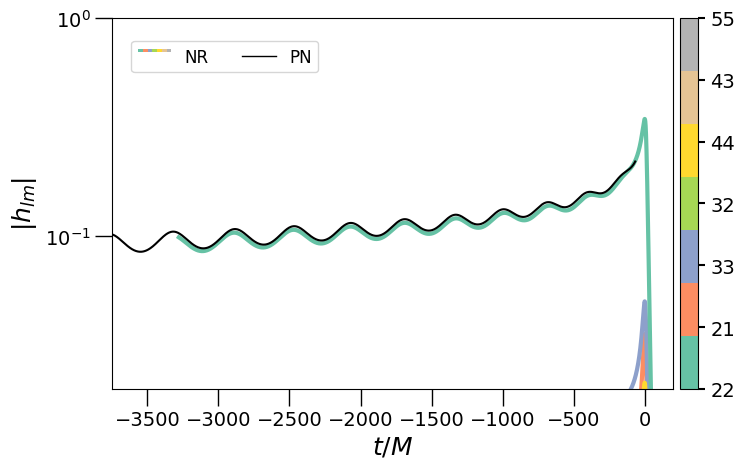

In [144]:
M0=M
M_SI=M0 * MSUN_SI
D_SI=(10**(6)) * PC_SI * 1
plt.figure(figsize=(8,4.8))
N = 7
cmap = plt.get_cmap('Set2', N)
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)


# Do calculate match 
#for i in range(0,200):
    




#NR data
plt.plot(tNR55- tNR55[np.argmax(NRamp55)] , NRamp55,linewidth = 3,c=cmap(6))
plt.plot(tNR21 - tNR21[np.argmax(NRamp21)] , NRamp21,linewidth = 3,c=cmap(1))
plt.plot(tNR33 - tNR33[np.argmax(NRamp33)] , NRamp33,linewidth = 3,c=cmap(2))
plt.plot(tNR32 - tNR32[np.argmax(NRamp32)] , NRamp32,linewidth = 3,c=cmap(3))
plt.plot(tNR44 - tNR44[np.argmax(NRamp44)] , NRamp44,linewidth = 3,c=cmap(4))
plt.plot(tNR43 - tNR43[np.argmax(NRamp43)] , NRamp43,linewidth = 3,c=cmap(5))
plt.plot(tNR22-tNR22[np.argmax(NRamp22)], NRamp22,linewidth = 3,c=cmap(0))


plt.semilogy(tvec-65,Amp22,'k-',label='EccTD') #tvec-120,60,12

plt.ylim(ymax=1e0)
plt.ylim(ymin=2e-2)
plt.xlim(xmin=-3750)
plt.xlim(xmax=200)

plt.ylabel(r'$|h_{lm}|$',size=18)
plt.xlabel(r'$t/M$',size=18)
plt.yscale('log')


plt.minorticks_off()
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
                          width / self.num_stripes, 
                          height/4.5, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
cmaps = [plt.get_cmap('Set2', 7)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line2, y_line2)


lgd = Line2D([0], [0], color='black', lw=1)   
    
cmap_labels = ["NR","PN"]
cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles.append(lgd)
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,bbox_to_anchor=(0.02,0.96),prop={'size': 12}, ncol = 2, loc=2)



plt.show()